In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='kidneyData.csv', dest_path = '/content/dataset/kidneyData')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dataset/archive (4)/kidneyData.csv')

In [ ]:
data

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


In [ ]:
 data['Class'].unique()

array(['Tumor', 'Normal', 'Stone', 'Cyst'], dtype=object)

In [ ]:
data['target'].unique()

array([3, 1, 2, 0])

In [ ]:
kidney_classes = data['Class'].value_counts()
kidney_classes

Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: Class, dtype: int64

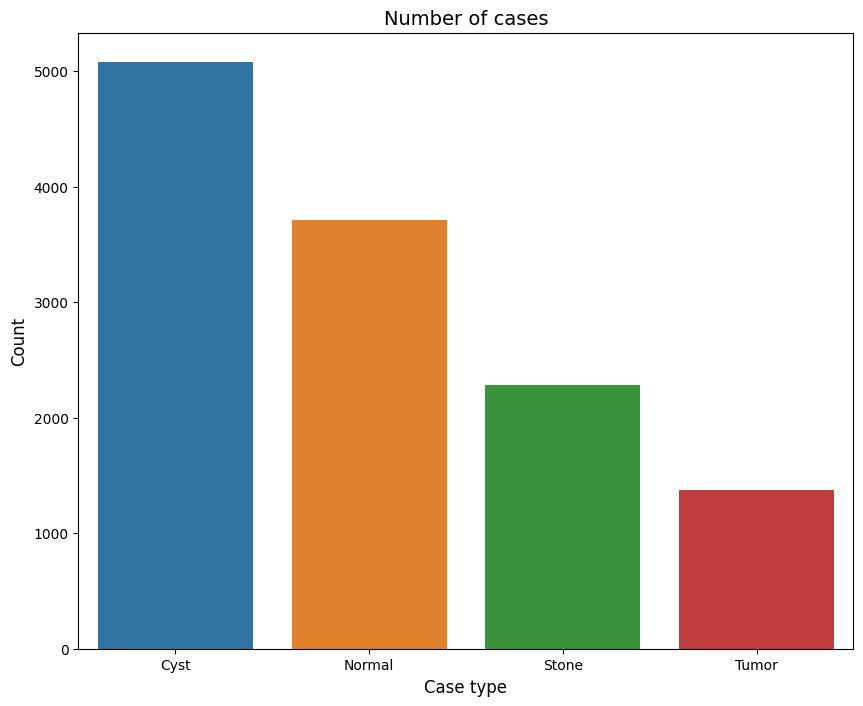

In [ ]:
# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=kidney_classes.index, y= kidney_classes.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(kidney_classes.index)), ['Cyst','Normal', 'Stone', 'Tumor'])
plt.show()

In [ ]:
!pip install -U -q tensorflow-addons
!pip install --upgrade tensorflow-hub
!pip install imbalanced-learn
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
import splitfolders
splitfolders.ratio(
    "/content/drive/MyDrive/dataset/archive (4)/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=101,
   ratio=(0.8,0.1, 0.1)
)

Copying files: 10310 files [06:49, 25.18 files/s]


In [ ]:
path = '/content/dataset/train/Normal'
dir_list = os.listdir(path)
print(len(dir_list))

4069


In [ ]:
import os
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE

# Define a function to load and preprocess images
def load_and_preprocess_images(input_folder, image_size):
    class_folders = os.listdir(input_folder)
    image_data = []
    labels = []

    for class_folder in class_folders:
        class_path = os.path.join(input_folder, class_folder)
        class_label = class_folder

        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)  # Resize the image to 128x128
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
            image = image / 255.0  # Normalize the pixel values to the range [0, 1]

            image_data.append(image)
            labels.append(class_label)

    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels
# Define a function to apply SMOTE and balance the images
def apply_smote_and_balance_images(input_folder, output_folder, desired_class_size, image_size):
    train_folder = os.path.join(input_folder, "train")
    image_data, labels = load_and_preprocess_images(train_folder, image_size)

    # Flatten the 2D image data to 1D
    image_data = image_data.reshape(image_data.shape[0], -1)

    # Define the SMOTE ratio based on the desired class size
    smote_ratio = {class_label: desired_class_size for class_label in np.unique(labels)}

    # Apply SMOTE to balance the dataset
    smote = SMOTE(sampling_strategy=smote_ratio)
    synthetic_data, synthetic_labels = smote.fit_resample(image_data, labels)

    # Reshape the synthetic data back into images
    synthetic_data = synthetic_data.reshape(synthetic_data.shape[0], *image_size)
     # Create the balanced dataset folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    train_output_folder = os.path.join(output_folder, "train")

    for class_label in np.unique(synthetic_labels):
        class_folder = os.path.join(train_output_folder, class_label)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

    # Save the synthetic images to the output folder
    for i, synthetic_image in enumerate(synthetic_data):
        class_label = synthetic_labels[i]
        class_folder = os.path.join(train_output_folder, class_label)
        filename = f"synthetic_{i}.png"
        image_path = os.path.join(class_folder, filename)
        synthetic_image = (synthetic_image * 255).astype(np.uint8) # Convert back to 0-255 range
        cv2.imwrite(image_path, synthetic_image)

# Define input and output folders
input_folder = '/content/dataset'
output_folder = '/content/balanced_dataset'
desired_class_size = 4069
image_size = (160, 160)

# Apply SMOTE and balance the images in the "train" folder
apply_smote_and_balance_images(input_folder, output_folder, desired_class_size, image_size)


In [ ]:
files = 0
path = '/content/dataset/train/Cyst'
dir_list = os.listdir(path)
print(len(dir_list))
files = len(dir_list)
path = '/content/dataset/train/Normal'
dir_list = os.listdir(path)
files += len(dir_list)
print(len(dir_list))
path = '/content/dataset/train/Tumor'
dir_list = os.listdir(path)
files += len(dir_list)
print(len(dir_list))
path = '/content/dataset/train/Stone'
dir_list = os.listdir(path)
files += len(dir_list)
print(len(dir_list))

files

1242
4069
1834
1101


8246

Label: Stone


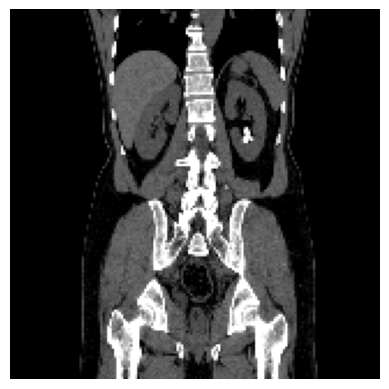

Label: Tumor


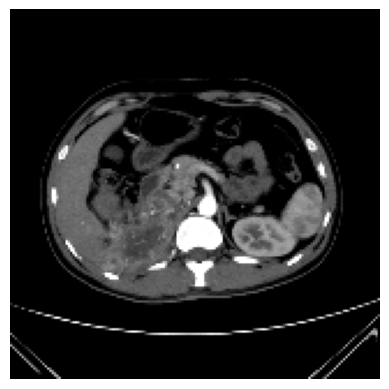

Label: Stone


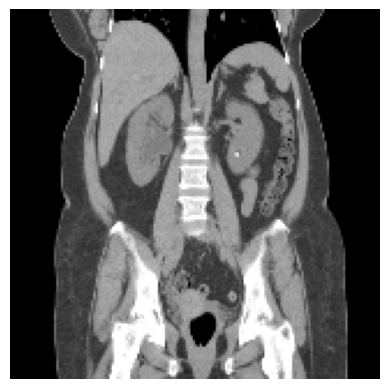

Label: Tumor


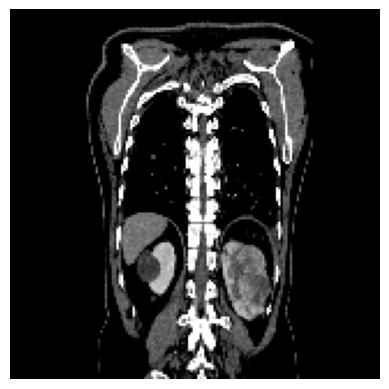

Label: Cyst


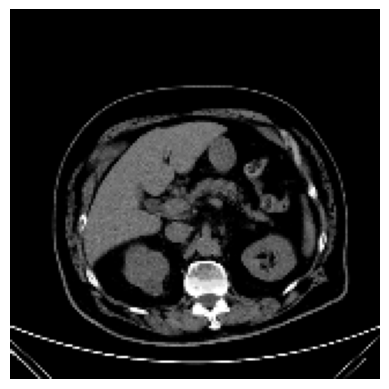

Label: Tumor


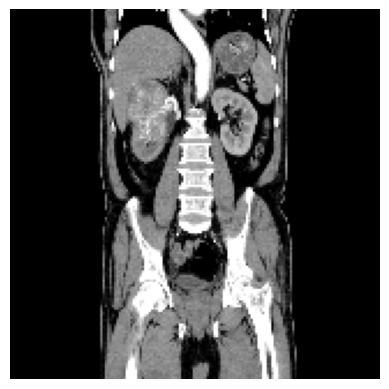

Label: Stone


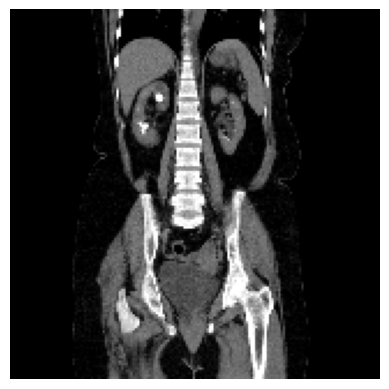

Label: Cyst


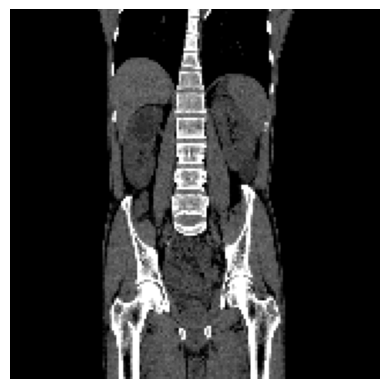

Label: Cyst


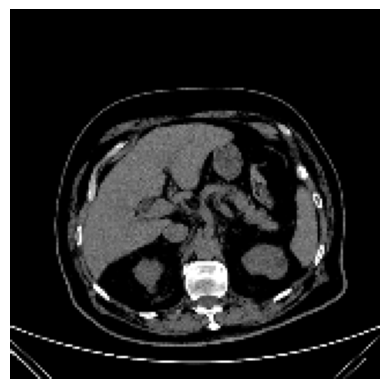

Label: Cyst


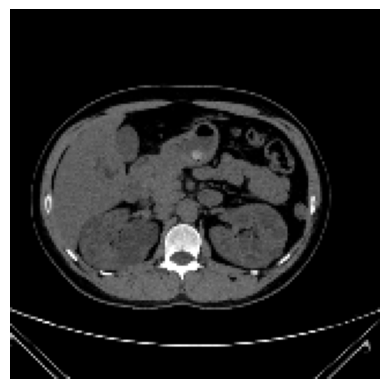

Label: Cyst


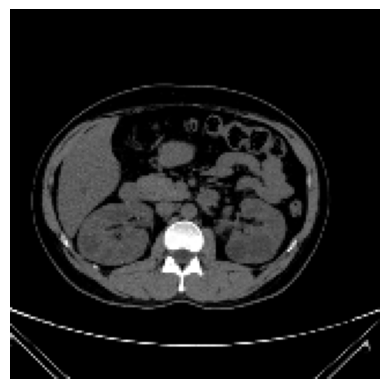

Label: Cyst


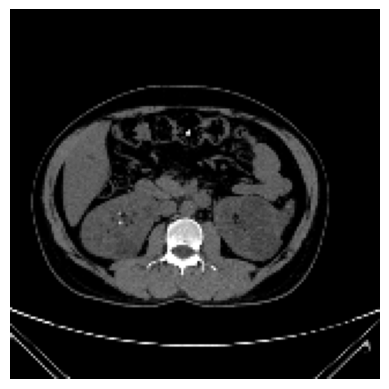

In [ ]:
import os
import cv2
import random

def load_and_preprocess_images(input_folder, image_size):
    image_data = []
    labels = []

    class_folders = os.listdir(input_folder)

    for class_folder in class_folders:
        class_path = os.path.join(input_folder, class_folder)
          # Skip non-directory items (e.g., files) in the input folder
        if not os.path.isdir(class_path):
            continue

        image_files = os.listdir(class_path)

        for image_filename in image_files:
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)

            # Check if the image is valid (not empty)
            if image is not None:
                image = cv2.resize(image, image_size)  # Resize the image to the specified size
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                image = image / 255.0  # Normalize pixel values to the range [0, 1]
                image_data.append(image)
                labels.append(class_folder)

    return image_data, labels

def view_random_samples(input_folder, num_samples):
    image_data, labels = load_and_preprocess_images(input_folder, image_size)

    if num_samples >= len(image_data):
        num_samples = len(image_data)

    random_indices = random.sample(range(len(image_data)), num_samples)

    for index in random_indices:
        image = image_data[index]
        label = labels[index]
        print(f"Label: {label}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()

# Define input folder (the folder containing the balanced images)
input_folder = '/content/balanced_dataset/train'
image_size = (160, 160)

# Number of random samples to view
num_samples_to_view = 12

# View random samples of images (including synthetic ones)
view_random_samples(input_folder, num_samples_to_view)

In [ ]:
#Run only first time
import shutil

# Source and destination folder paths
source_folder = '/content/dataset/test'  # Replace with the path of the source folder you want to copy
destination_folder = '/content/balanced_dataset/test'  # Replace with the path of the destination folder

# Use shutil.copytree to recursively copy the source folder to the destination folder
shutil.copytree(source_folder, destination_folder)

print(f"Folder '{source_folder}' copied to '{destination_folder}'")

Folder '/content/dataset/test' copied to '/content/balanced_dataset/test'


In [ ]:
#Run only first time
import shutil

# Source and destination folder paths
source_folder = '/content/dataset/val'  # Replace with the path of the source folder you want to copy
destination_folder = '/content/balanced_dataset/val'  # Replace with the path of the destination folder

# Use shutil.copytree to recursively copy the source folder to the destination folder
shutil.copytree(source_folder, destination_folder)

print(f"Folder '{source_folder}' copied to '{destination_folder}'")

Folder '/content/dataset/val' copied to '/content/balanced_dataset/val'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.2,
    vertical_flip=True,
    horizontal_flip = True,
    fill_mode="reflect")
train_generator = train_datagen.flow_from_directory(
    './balanced_dataset/train',
    target_size=(160, 160),
    class_mode='categorical',
    batch_size = 64,)
val_datagen = ImageDataGenerator(rescale = 1/255.0)
val_generator = train_datagen.flow_from_directory(
     './balanced_dataset/val',
    target_size=(160, 160),
    class_mode='categorical',
    batch_size = 64,)

Found 16276 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.


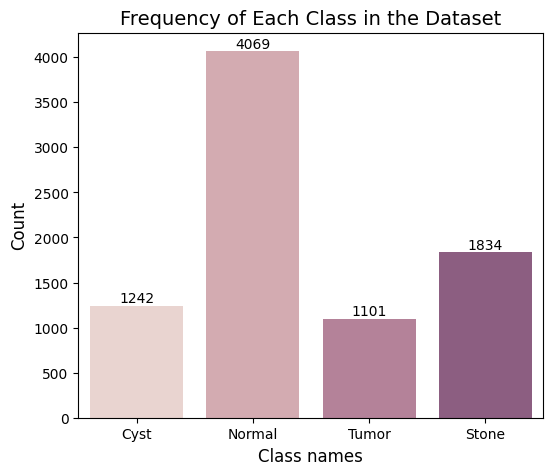

In [ ]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone']

cyst = len(os.listdir('/content/dataset/train/Cyst'))
normal = len(os.listdir('/content/dataset/train/Normal'))
tumor = len(os.listdir('/content/dataset/train/Tumor'))
stone = len(os.listdir('/content/dataset/train/Stone'))

images = [cyst, normal, stone, tumor]
plt.figure(figsize=(6,5))
ax = sns.barplot(x= class_names, y= images, palette= sns.cubehelix_palette())
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Frequency of Each Class in the Dataset', fontsize=14)
plt.xlabel('Class names', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(images)))
plt.show()
px.pie(names= class_names, values= images, color_discrete_sequence=px.colors.sequential.BuGn)

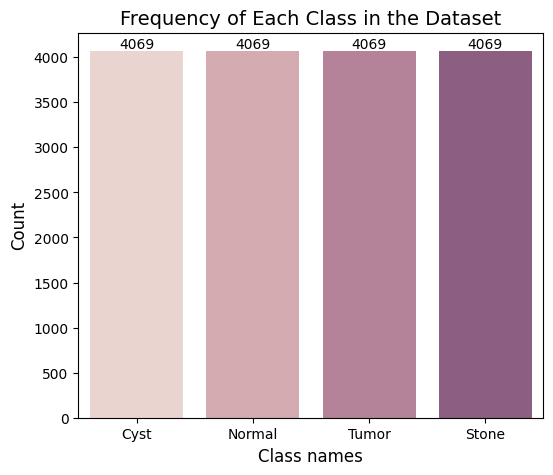

In [ ]:
lass_names = ['Cyst', 'Normal', 'Tumor', 'Stone']

cyst = len(os.listdir('/content/balanced_dataset/train/Cyst'))
normal = len(os.listdir('/content/balanced_dataset/train/Normal'))
tumor = len(os.listdir('/content/balanced_dataset/train/Tumor'))
stone = len(os.listdir('/content/balanced_dataset/train/Stone'))

images = [cyst, normal, stone, tumor]
plt.figure(figsize=(6,5))
ax = sns.barplot(x= class_names, y= images, palette= sns.cubehelix_palette())
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Frequency of Each Class in the Dataset', fontsize=14)
plt.xlabel('Class names', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(images)))
plt.show()
px.pie(names= class_names, values= images, color_discrete_sequence=px.colors.sequential.BuGn)

In [ ]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone']
def class_type(dataset, n_images):

    i = 1
    images, labels = dataset.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[np.argmax(label)])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    plt.show()
train = '/content/dataset/train'
class_type(train, 10)

AttributeError: ignored